In [2]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ignore the verson warning
from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
# Load the data
raw_data = pd.read_csv('./source/38,102,104, 84.csv', encoding='utf-8')
raw_data.head()

,circuit_uuid,exp_id,run_uuid,chip_id,chip_ver,chip_idx,cir_idx,cir_ver,cir_vers,overall_idx,...,fill_factor_initial,included,neg,neg_0,neg_1,pos_0,pos_0_inc,pos_1,pos_1_inc,total_droplets
0,1a98c2ab-487a-42a8-b290-74a798e905be,EXP-VGXT8LA5,10ab869d-6439-44be-9013-025905656caf,VF6J7L4S,v4,0,0,NaN,NaN,0,...,1.0,21551,21061,21061,21551,506,490,0,0,23135
1,79ac9af0-279b-4424-a6ca-80121c653d43,EXP-VGXT8LA5,10ab869d-6439-44be-9013-025905656caf,VF6J7L4S,v4,0,1,NaN,NaN,1,...,1.0,20894,20416,20416,20894,485,478,0,0,22031
2,6920caef-ddfb-4202-96fd-282541fa73b7,EXP-VGXT8LA5,10ab869d-6439-44be-9013-025905656caf,VF6J7L4S,v4,0,2,NaN,NaN,2,...,1.0,22497,22046,22046,22497,459,451,0,0,24168
3,cb9f207f-099a-48f8-9053-d681e4f73cf5,EXP-VGXT8LA5,10ab869d-6439-44be-9013-025905656caf,VF6J7L4S,v4,0,3,NaN,NaN,3,...,1.0,20462,19957,19957,20462,508,505,0,0,21581
4,c6409fd6-b632-452e-8c25-aff70e5f120c,EXP-VGXT8LA5,10ab869d-6439-44be-9013-025905656caf,VF6J7L4S,v4,0,4,NaN,NaN,4,...,1.0,21401,20914,20914,21401,515,487,0,0,23102


In [4]:
# Fiter the raw data, keep columns: reaction, specimen， fill_factor_final, fill_factor_initial, doublets, total_droplets
columns_to_keep = ['reaction', 'specimen', 'fill_factor_final',
                   'fill_factor_initial', 'doublets', 'total_droplets']
filtered_data = raw_data[columns_to_keep]
filtered_data.head()

,reaction,specimen,fill_factor_final,fill_factor_initial,doublets,total_droplets
0,NK-R38,LR-S007-0528,1.0,1.0,57,23135
1,NK-R38,LR-S007-0528,1.0,1.0,48,22031
2,NK-R38,LR-S007-0528,1.0,1.0,34,24168
3,NK-R38,LR-S007-0528,1.0,1.0,42,21581
4,NK-R38,LR-S007-0528,1.0,1.0,51,23102


## Static Analysis

In [144]:
# group the data
grouped_data = filtered_data.groupby('reaction')

# calculate the aggregation
grouped_data_agg =(filtered_data.groupby('reaction')
                   .agg({
                    'specimen': 'count',
                    'fill_factor_final': 'mean',
                    'fill_factor_initial': 'mean',
                    'doublets': 'mean',
                    'total_droplets': 'mean'})
                    .reset_index()
    )

# Rename the columns
grouped_data_agg.rename(columns={
    'specimen': 'specimen_count',
    'fill_factor_final': 'mean_fill_factor_final',
    'fill_factor_initial': 'mean_fill_factor_initial',
    'doublets': 'mean_doublets',
    'total_droplets': 'mean_total_droplets'
}, inplace=True)

# Add new columns: fff/ffi
grouped_data_agg["fff/ffi_ratio"] = grouped_data_agg["mean_fill_factor_final"] / \
    grouped_data_agg["mean_fill_factor_initial"]

# Add new columns: fff/ffi_score
grouped_data_agg["fff/ffi_score"] = abs(1 - grouped_data_agg["fff/ffi_ratio"])

grouped_data_agg

,reaction,specimen_count,mean_fill_factor_final,mean_fill_factor_initial,mean_doublets,mean_total_droplets,fff/ffi_ratio,fff/ffi_score
0,NK-R102,200,0.992200,0.994550,103.470000,22582.865000,0.997637,0.002363
1,NK-R104,199,0.992714,0.993769,89.874372,22301.135678,0.998938,0.001062
2,NK-R38,198,0.993182,0.994394,102.242424,23404.883838,0.998781,0.001219
3,NK-R84,199,0.986231,0.992965,194.417085,21921.753769,0.993219,0.006781


In [102]:
# 颜色映射字典
palette = {
    'NK-R38': 'blue',
    'NK-R84': 'orange',
    'NK-R102': 'green',
    'NK-R104': 'red'
}

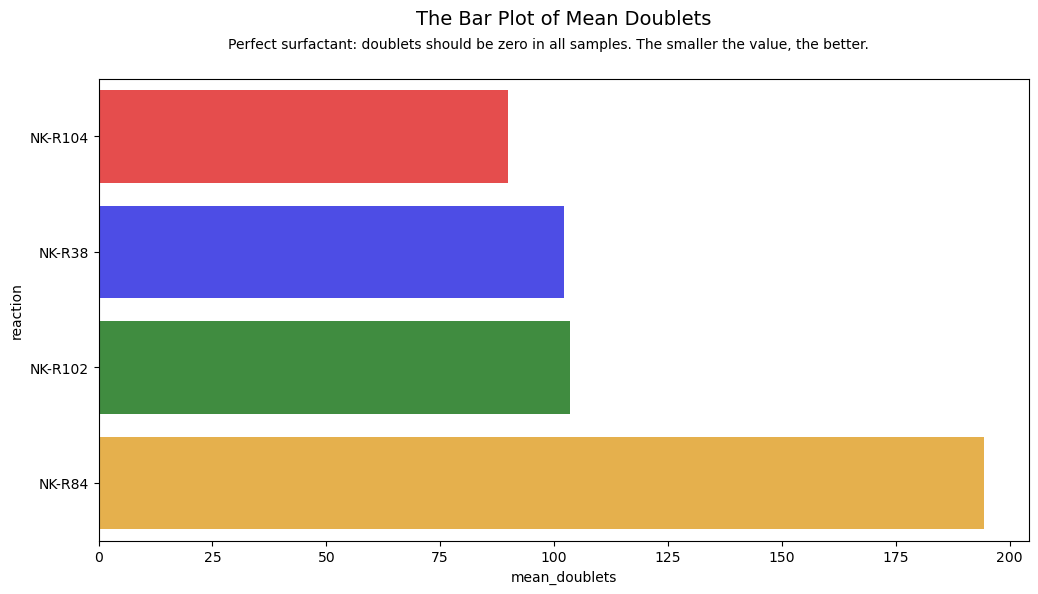

In [156]:
# Sorted the data Frame by mean_doublets
order_mean_doublets = (grouped_data_agg.sort_values(by='mean_doublets', ascending=True)['reaction']
                       .tolist())

# bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='mean_doublets',  y='reaction',  data=grouped_data_agg,
            order=order_mean_doublets, palette=palette, alpha=0.8)

# Title and suptitle
plt.title("The Bar Plot of Mean Doublets", fontsize=14, y=1.1)
plt.suptitle("Perfect surfactant: doublets should be zero in all samples. The smaller the value, the better.", fontsize=10, y=0.95)
plt.show()

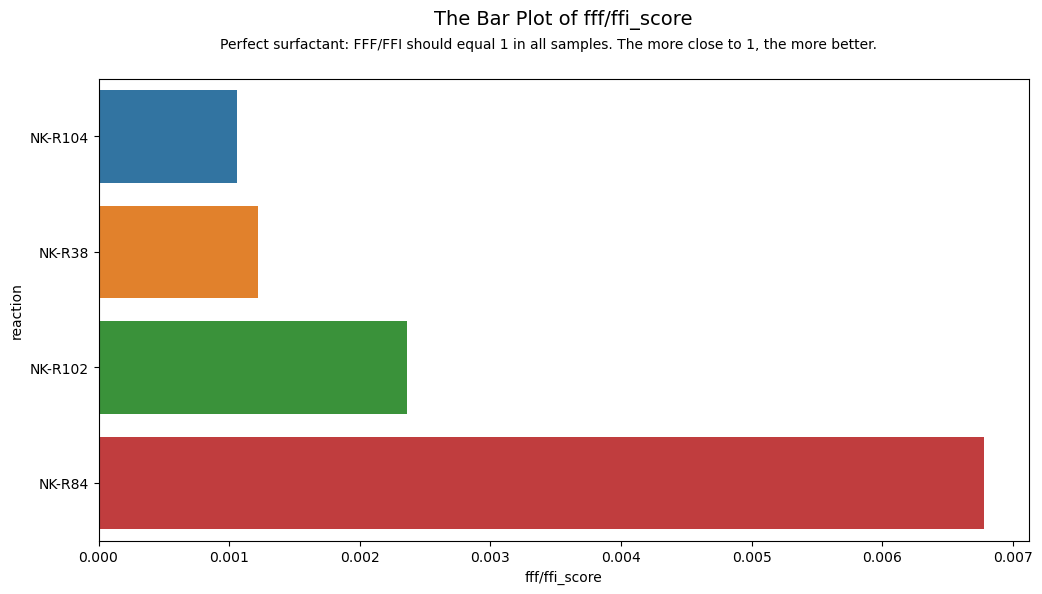

In [154]:
# Sorted the data Frame by fff/ffi_score
order_fffffi_score = (grouped_data_agg.sort_values(by='fff/ffi_score', ascending=True)['reaction']
         .tolist())
# bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='fff/ffi_score',  y='reaction',
            data=grouped_data_agg, order=order_fffffi_score,
            )
#Title and Suptitle
plt.title("The Bar Plot of fff/ffi_score", fontsize=14, y=1.1)
plt.suptitle("Perfect surfactant: FFF/FFI should equal 1 in all samples. The more close to 1, the more better.", fontsize=10, y=0.95)
plt.show()

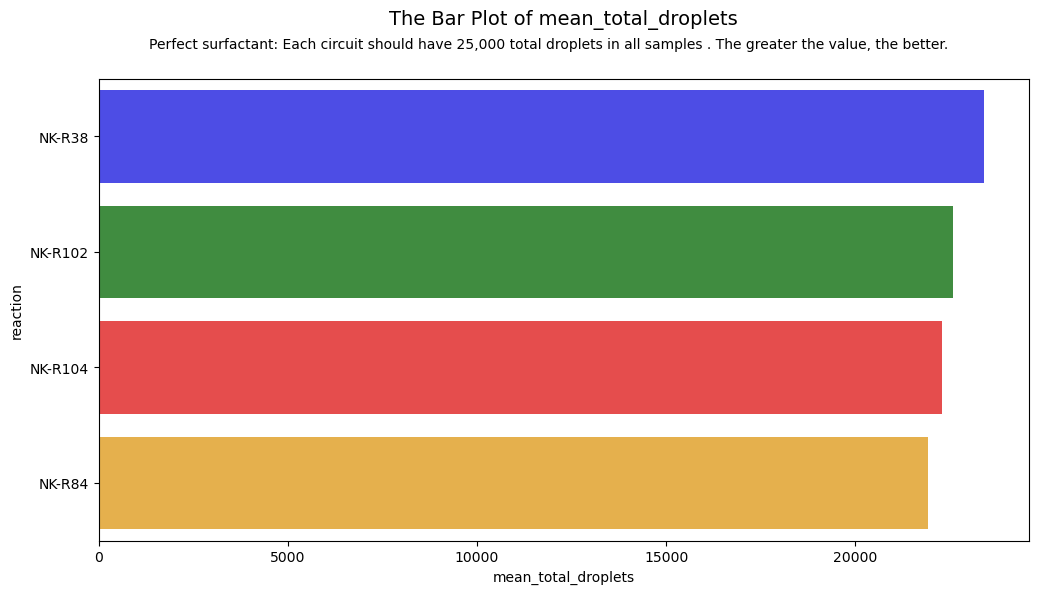

In [153]:
# Sorted the data Frame by fff/ffi_ratio
order_mean_total_droplets = (grouped_data_agg.sort_values(by='mean_total_droplets', ascending=False)['reaction']
         .tolist())

# bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='mean_total_droplets',  y='reaction',  data=grouped_data_agg,
            order=order_mean_total_droplets, palette=palette, alpha=0.8)

# Title and Suptitle
plt.title("The Bar Plot of mean_total_droplets", fontsize=14, y=1.1)
plt.suptitle("Perfect surfactant: Each circuit should have 25,000 total droplets in all samples. The greater the value, the better.", fontsize=10, y=0.95)
plt.show()

## Surfactant Stability Evaluation 

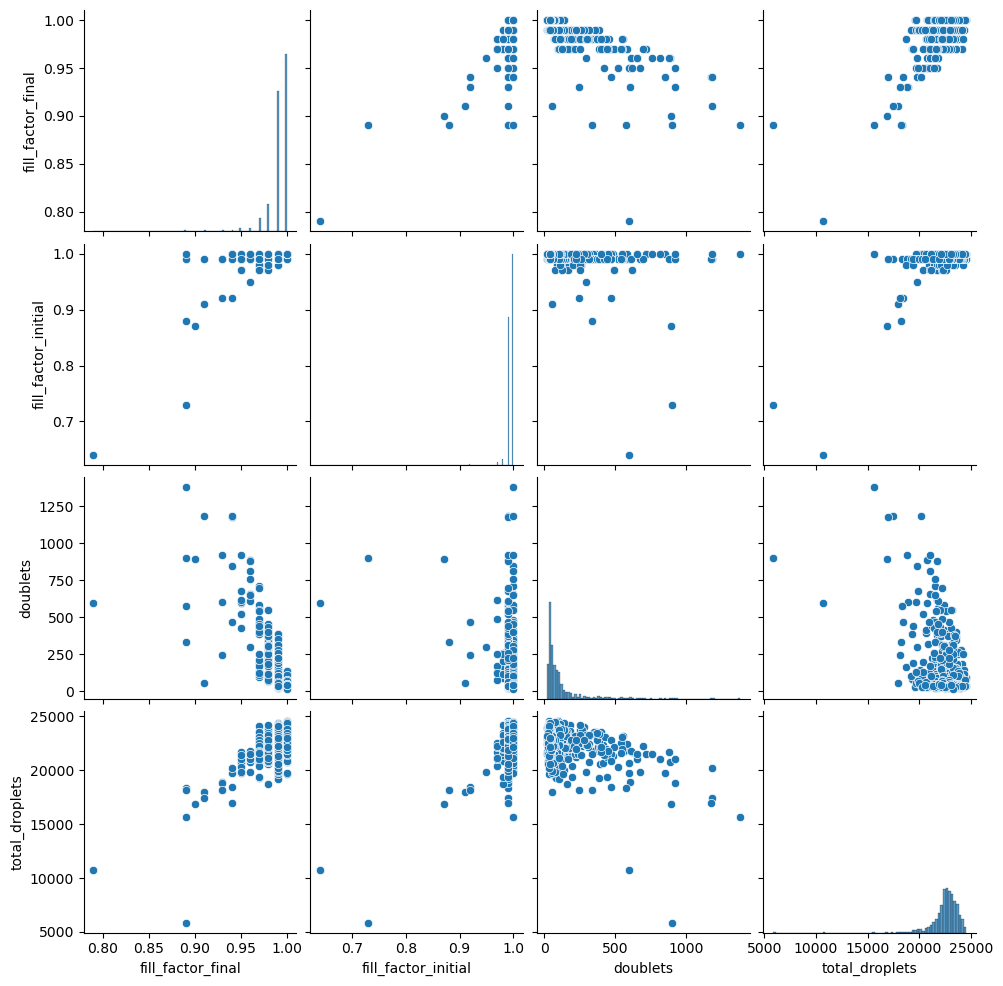

In [7]:
# The default diagonal uses histogram, non-diagonal uses scatter.
sns.pairplot(filtered_data)

##  Doublets by Specimen(easures how many drops coalesced)

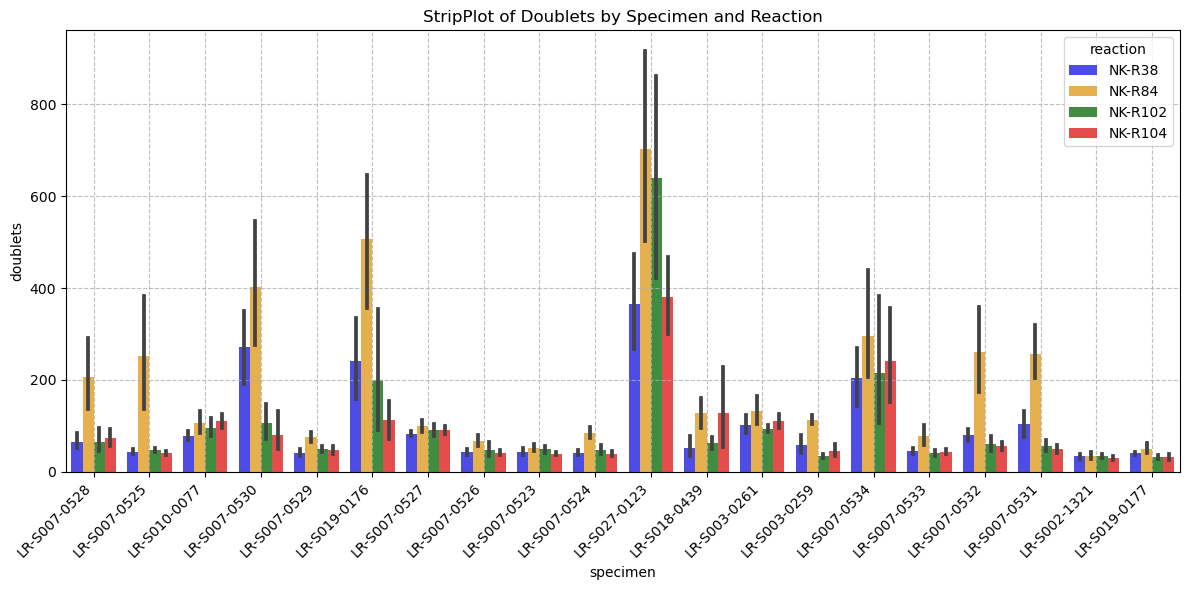

In [111]:
# Box plot
plt.figure(figsize=(12, 6))
sns.barplot(x="specimen", y="doublets", hue="reaction",
            data=filtered_data, palette=palette, alpha=0.8)

# Setting figure attributes
plt.title('StripPlot of Doublets by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis label
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()  # Adjust chart layout
plt.show()

### Chart Explanation

1. X-axis (specimen): Represents different specimen samples.
2. Y-axis (doublets): Indicates the number of doublets.
3. Legend (reaction): Each color corresponds to a reaction condition, including `NK-R38`, `NK-R84`, `NK-R102`, and `NK-R104`.
4. **Error bars (black lines)**: The black line on each bar represents the variance or standard error of that data group (usually standard error), reflecting the dispersion of the data. Longer error bars indicate greater variability in that data group; shorter error bars indicate less variability in that data group.

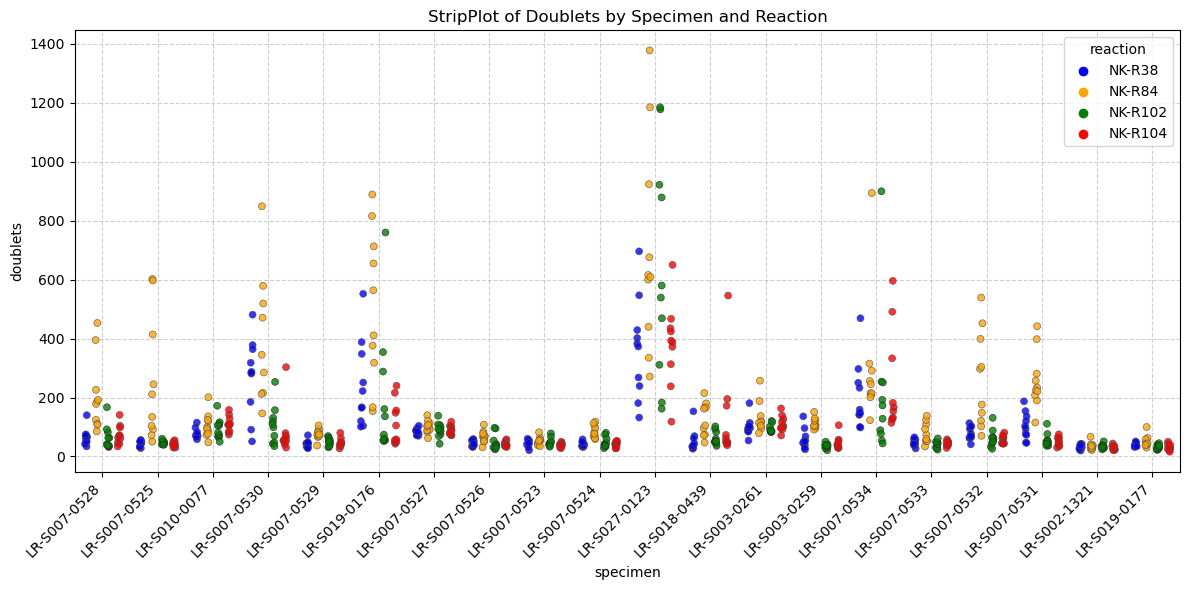

In [112]:
# Strpplot
plt.figure(figsize=(12, 6))

sns.stripplot(x="specimen", y="doublets", hue="reaction", data=filtered_data, 
              dodge=True, jitter=True, linewidth=0.5,
              palette=palette, alpha=0.8)

# Setting figure attributes
plt.title('StripPlot of Doublets by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis label
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.tight_layout()  # Adjust the layout
plt.show()

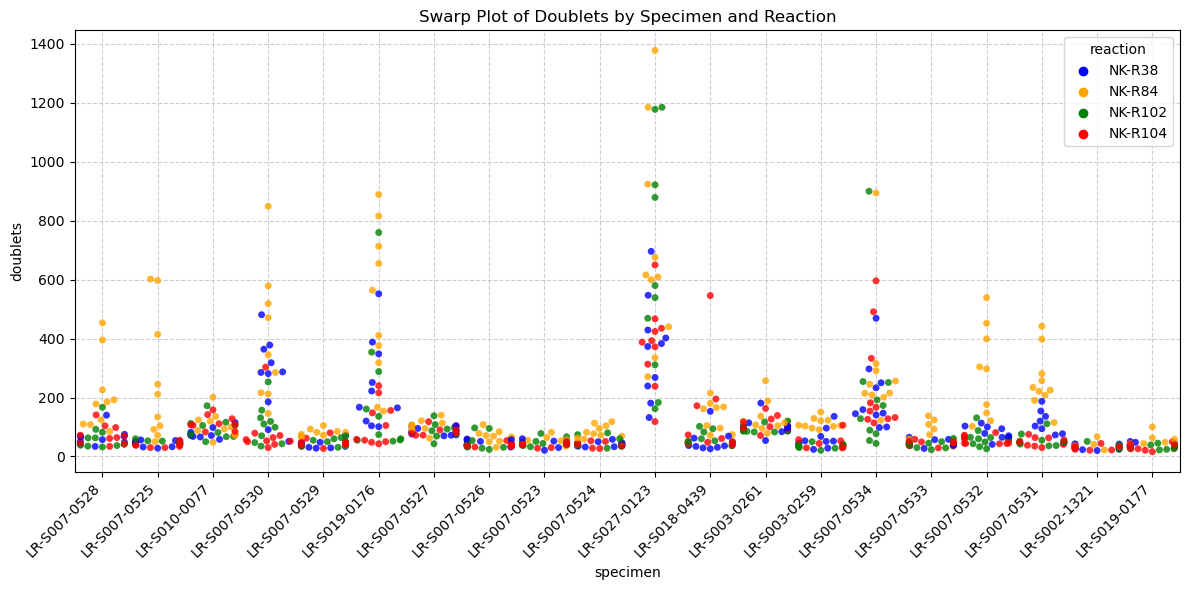

In [113]:
# Swarmplot
# Bee swarm plots can avoid point overlap, making the view more intuitive.
plt.figure(figsize=(12, 6))
sns.swarmplot(x="specimen", y="doublets", hue="reaction",
              data=filtered_data, palette=palette, alpha=0.8)

# Setting figure attributes
plt.title('Swarp Plot of Doublets by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.tight_layout()  # Adjust the layout
plt.show()

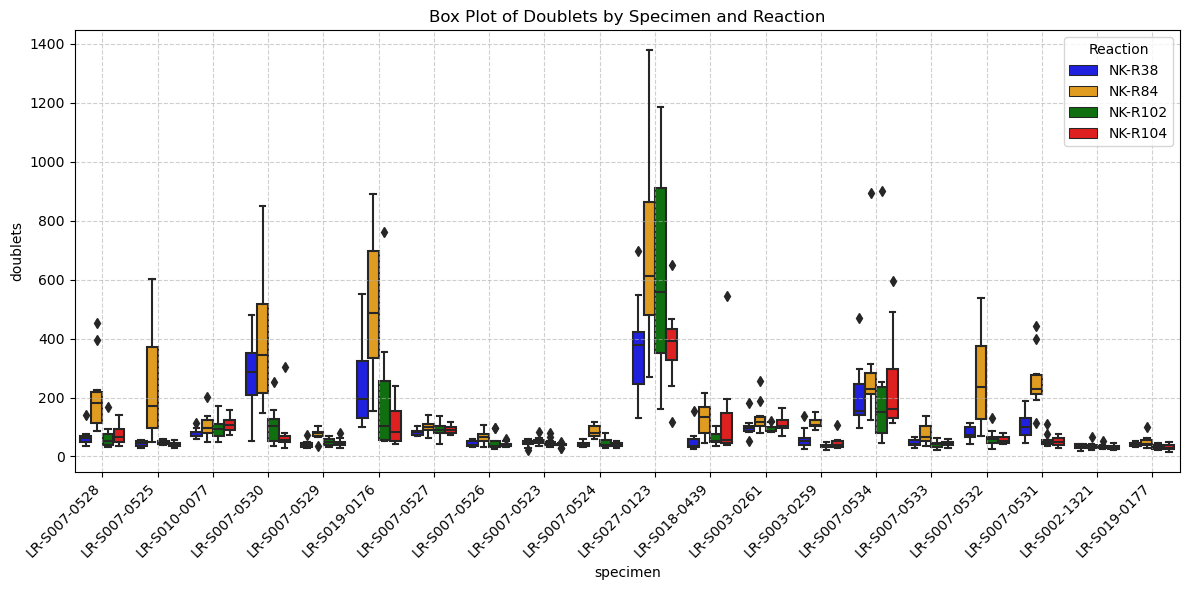

In [117]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='specimen', y='doublets', hue='reaction',
            data=filtered_data, palette=palette)

# Setting figure attributes
plt.title('Box Plot of Doublets by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis
plt.legend(title='Reaction', loc='upper right')
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.tight_layout()  # adjust the layout
plt.show()

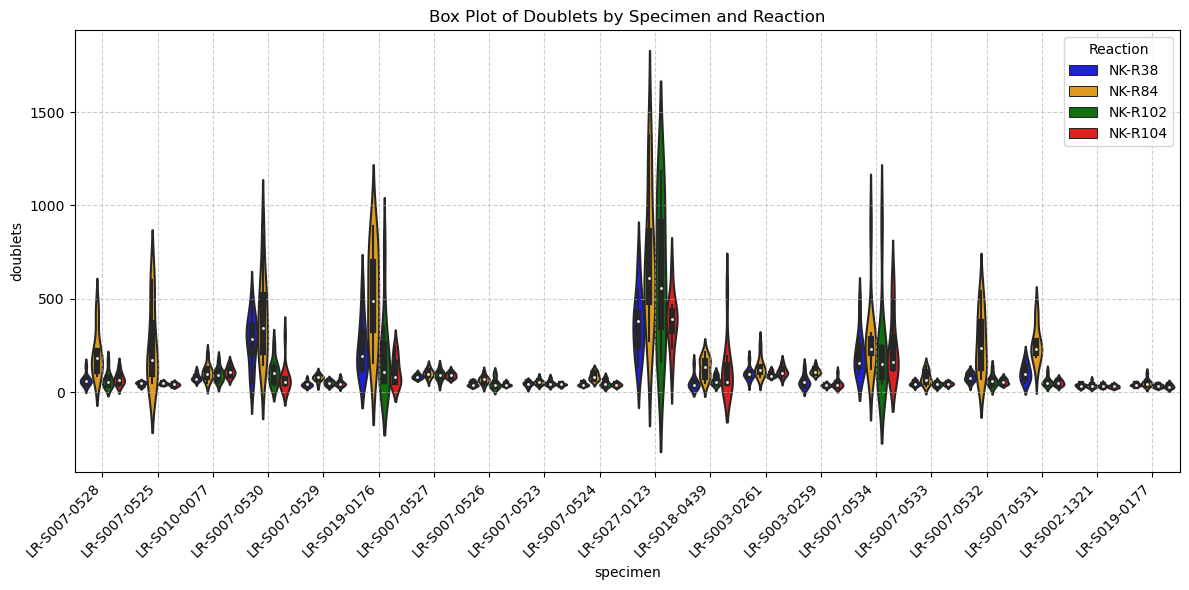

In [118]:
# violinplot
# The violin plot combines the advantages of a box plot and a kernel density estimate 
# plot, used to display the shape, central tendency, and variability of data 
# distribution.
plt.figure(figsize=(12, 6))
# scale could take three variables:
# count determines the width of each violin, 
# area makes each violin have the same area, 
# width makes each violin have the same width
sns.violinplot(x='specimen', y='doublets', hue='reaction', scale='count',
               data=filtered_data, palette=palette, alpha=0.8)

# Setting figure attributes
plt.title('Box Plot of Doublets by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate the x axis
plt.legend(title='Reaction', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # adjust the plot layout
plt.show()

## Total droplets by Specimen (when this number drops, its also a sign that droplets coalesced)

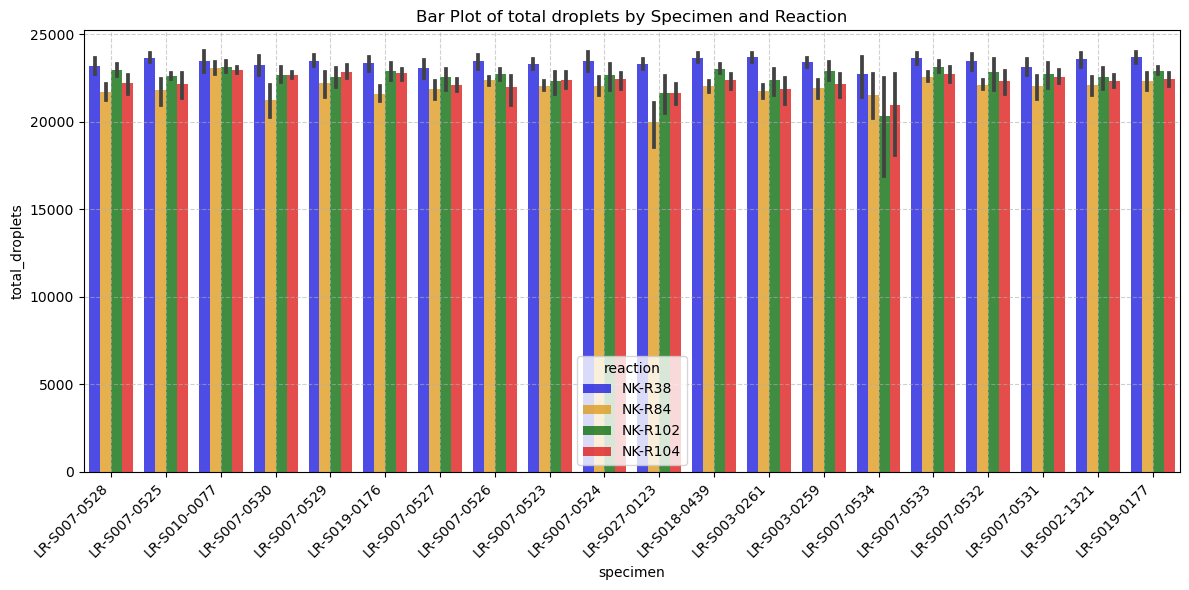

In [127]:
# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x="specimen", y="total_droplets",
            hue="reaction", data=filtered_data, palette=palette, alpha=0.8)

# Setting figure attributes
plt.title('Bar Plot of total droplets by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis label
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Adjust chart layout
plt.show()

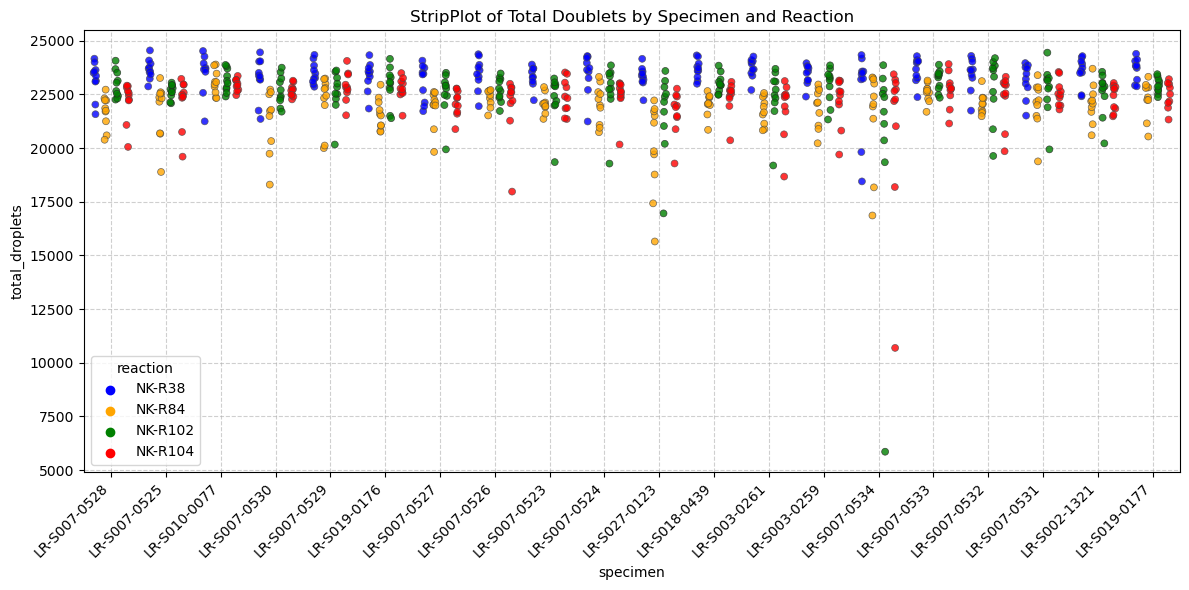

In [120]:
# Strpplot
plt.figure(figsize=(12, 6))
sns.stripplot(x="specimen", y="total_droplets", hue="reaction", data=filtered_data,
              dodge=True, jitter=True, linewidth=0.5, palette=palette, alpha=0.8)

# Setting figure attributes
plt.title('StripPlot of Total Doublets by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis label
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Adjust the layout
plt.show()

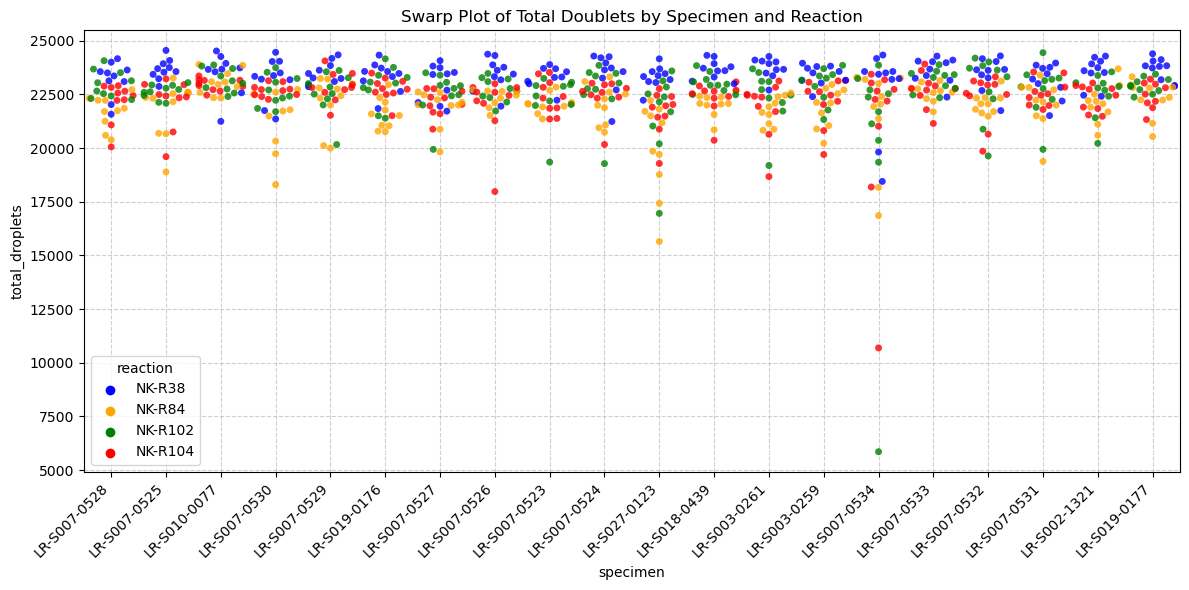

In [121]:
# Swarmplot
# Bee swarm plots can avoid point overlap, making the view more intuitive.
plt.figure(figsize=(12, 6))
sns.swarmplot(x="specimen", y="total_droplets",
              hue="reaction", data=filtered_data, palette=palette, alpha=0.8)

# Setting figure attributes
plt.title('Swarp Plot of Total Doublets by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Adjust the layout
plt.show()

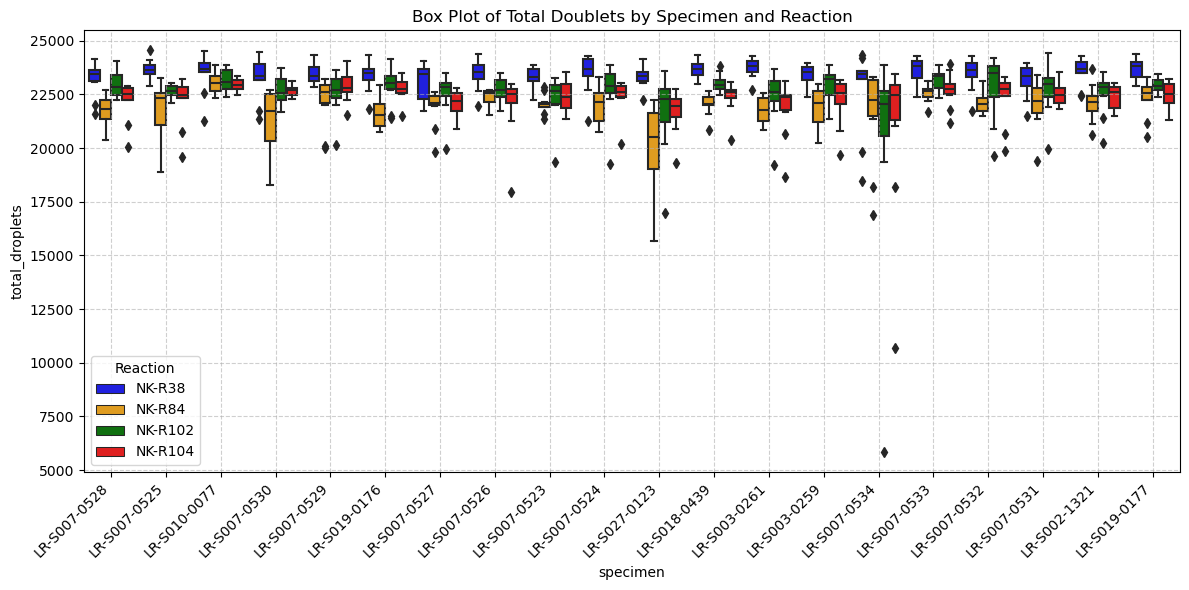

In [123]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='specimen', y='total_droplets', hue='reaction',
            data=filtered_data, palette=palette)

# Setting figure attributes
plt.title('Box Plot of Total Doublets by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis
plt.legend(title='Reaction', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # adjust the layout
plt.show()

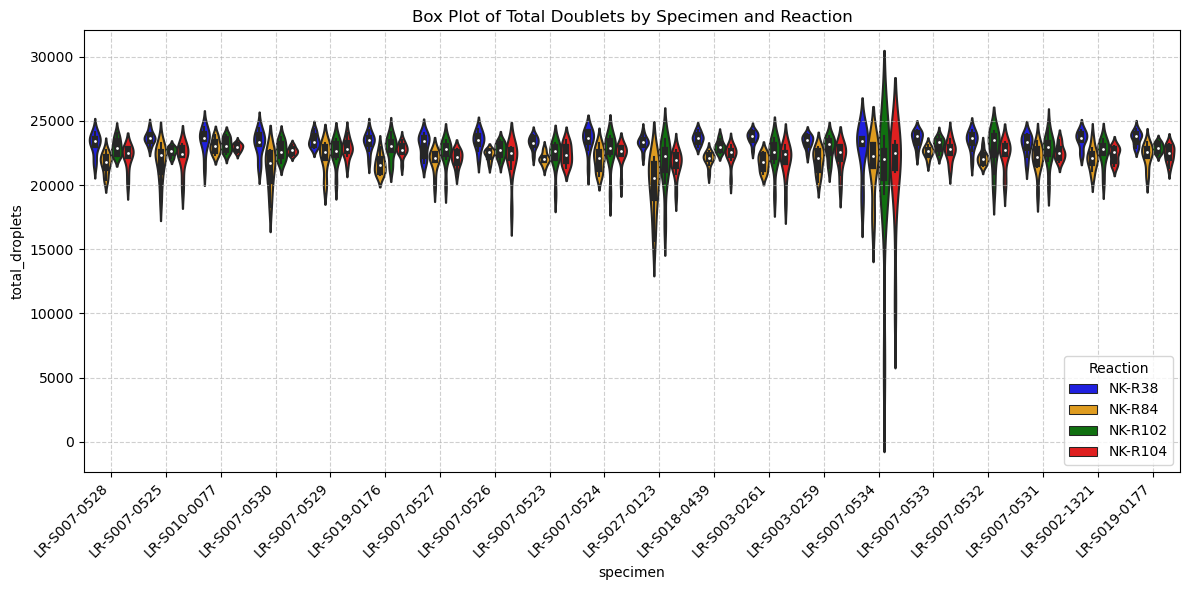

In [125]:
# violinplot
# The violin plot combines the advantages of a box plot and a kernel density estimate
# plot, used to display the shape, central tendency, and variability of data
# distribution.
plt.figure(figsize=(12, 6))
# scale could take three variables:
# count determines the width of each violin,
# area makes each violin have the same area,
# width makes each violin have the same width
sns.violinplot(x='specimen', y='total_droplets', hue='reaction', scale='count',
               data=filtered_data, palette=palette, alpha=0.8)

# Setting figure attributes
plt.title('Box Plot of Total Doublets by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate the x axis
plt.legend(title='Reaction', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # adjust the plot layout
plt.show()

## Fill factor intial/fillfactor final (when this number moves away from 1, its means droplets coalesced) 

In [39]:
y_axis = filtered_data['fill_factor_final'] / \
    filtered_data['fill_factor_initial']

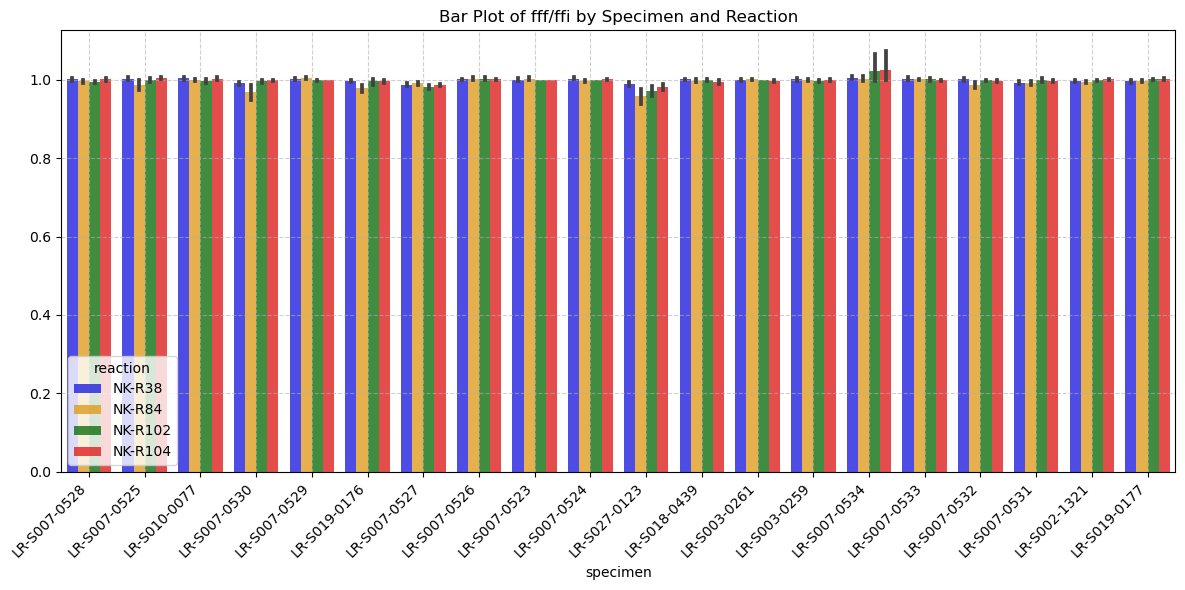

In [128]:
# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x="specimen", y=y_axis,
            hue="reaction", data=filtered_data, palette=palette, alpha=0.8)

# Setting figure attributes
plt.title('Bar Plot of fff/ffi by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis label
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Adjust chart layout
plt.show()

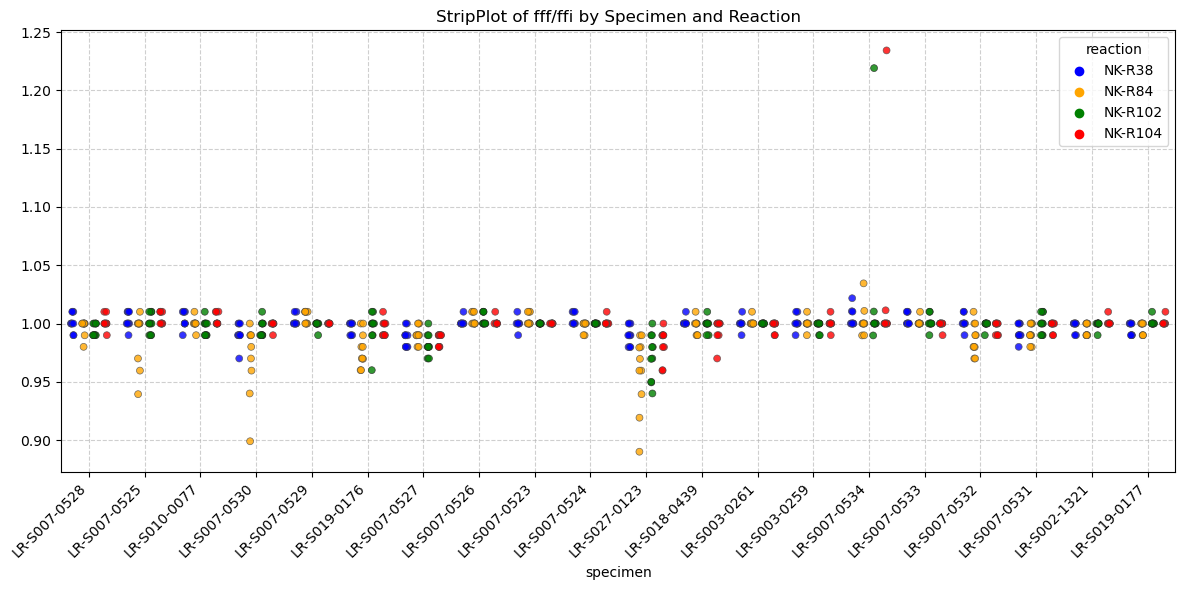

In [129]:
# Strpplot
plt.figure(figsize=(12, 6))
sns.stripplot(x="specimen", y=y_axis,hue="reaction", data=filtered_data,
              dodge=True, jitter=True, linewidth=0.5, palette=palette, alpha=0.8)

# Setting figure attributes
plt.title('StripPlot of fff/ffi by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis label
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Adjust the layout
plt.show()

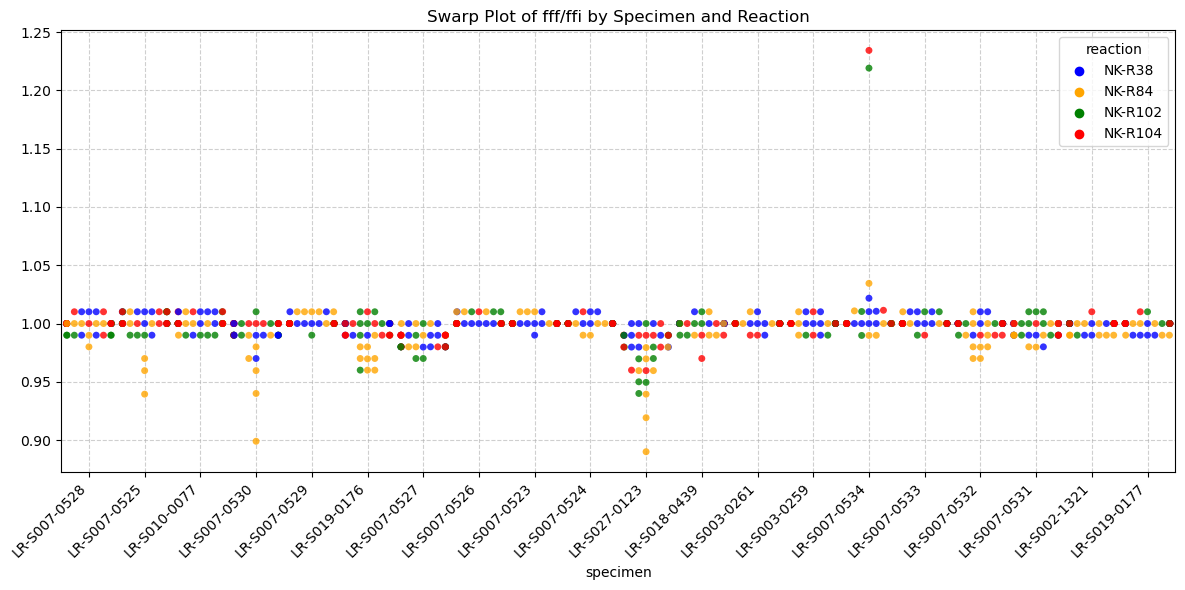

In [130]:
# Swarmplot
# Bee swarm plots can avoid point overlap, making the view more intuitive.
plt.figure(figsize=(12, 6))
sns.swarmplot(x="specimen", y=y_axis,
              hue="reaction", data=filtered_data, palette=palette, alpha=0.8)

# Setting figure attributes
plt.title('Swarp Plot of fff/ffi by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Adjust the layout
plt.show()

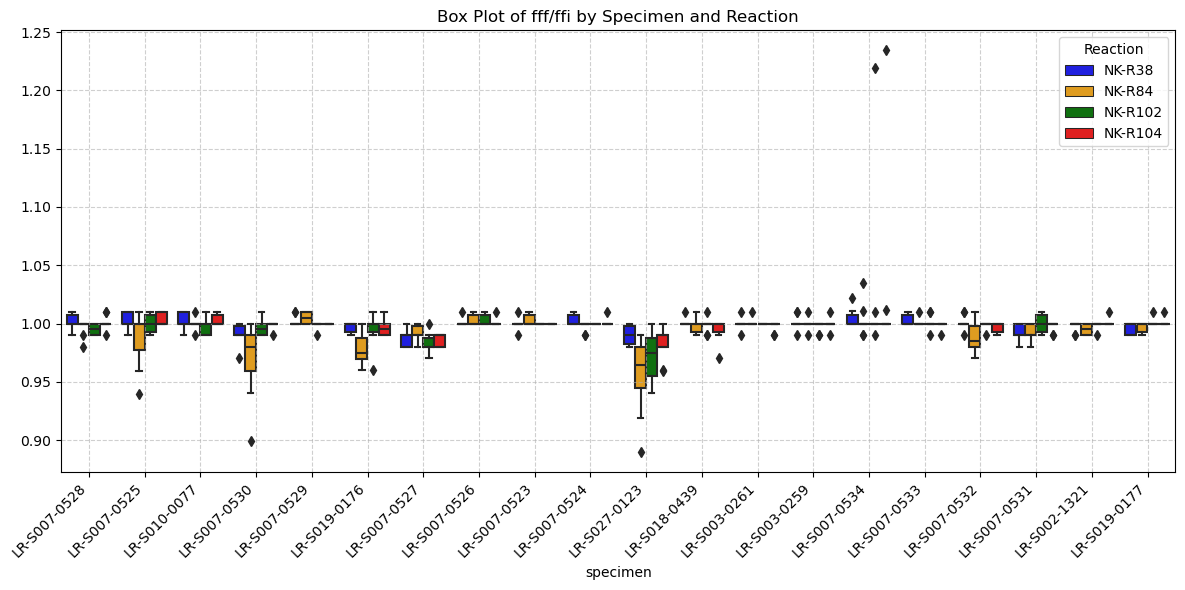

In [135]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='specimen', y=y_axis, hue='reaction',
            data=filtered_data, palette=palette)

# Setting figure attributes
plt.title('Box Plot of fff/ffi by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis
plt.legend(title='Reaction', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # adjust the layout
plt.show()

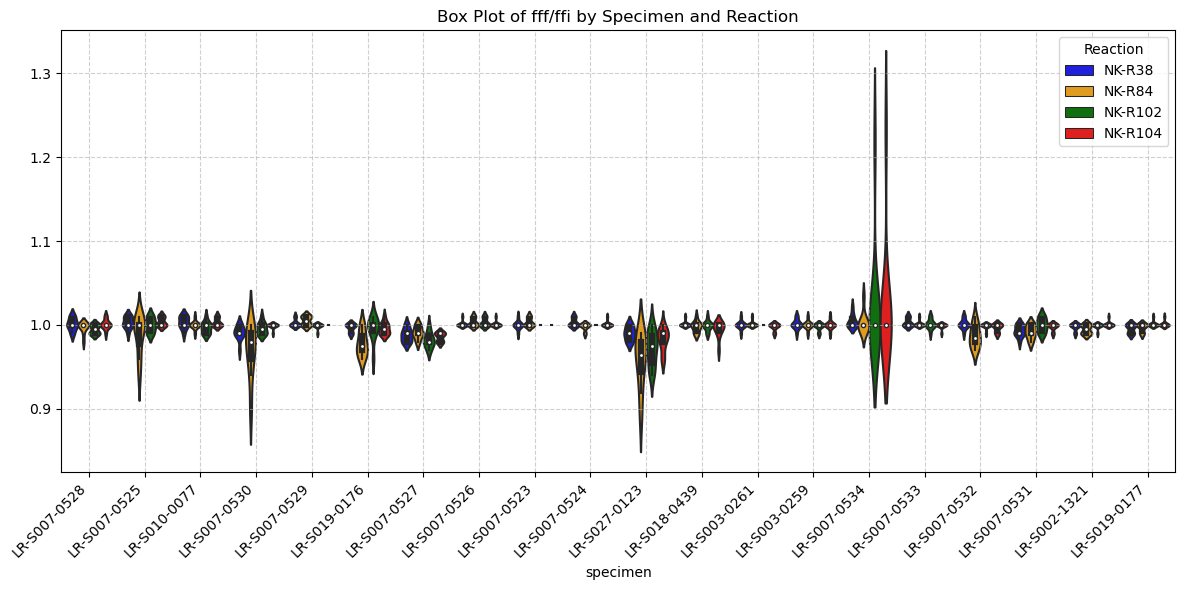

In [133]:
# violinplot
# The violin plot combines the advantages of a box plot and a kernel density estimate
# plot, used to display the shape, central tendency, and variability of data
# distribution.
plt.figure(figsize=(12, 6))
# scale could take three variables:
# count determines the width of each violin,
# area makes each violin have the same area,
# width makes each violin have the same width
sns.violinplot(x='specimen', y=y_axis, hue='reaction', scale='count',
               data=filtered_data, palette=palette, alpha=0.8)

# Setting figure attributes
plt.title('Box Plot of fff/ffi by Specimen and Reaction')
plt.xticks(rotation=45, ha='right')  # Rotate the x axis
plt.legend(title='Reaction', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # adjust the plot layout
plt.show()